### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    Ziyang Huang

**Student ID:**     1067800

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [1]:
import os
import numpy as np
import cv2  
from matplotlib import pyplot as plt
import math

### 1. Load images and compute correspondences


In [2]:
# Read in images from a filepath as graycsale.
rootpath='./kusvod2/'
picA = cv2.imread(os.path.join(rootpath, 'bookshA.png'),cv2.IMREAD_GRAYSCALE)
picB = cv2.imread(os.path.join(rootpath, 'bookshB.png'),cv2.IMREAD_GRAYSCALE)

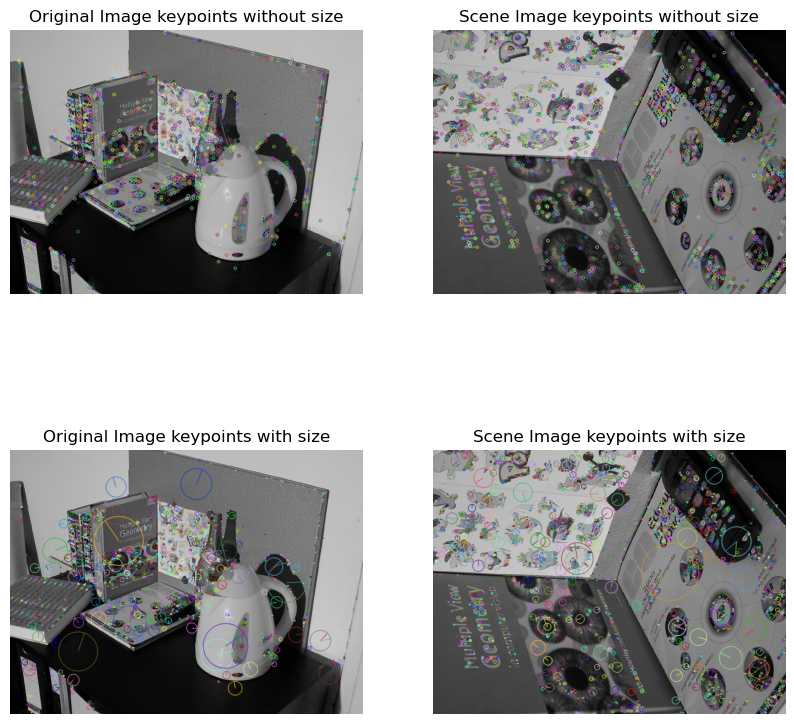

Number of keypoints detected in picA:  1265
Number of keypoints detected in picB:  2183


In [3]:
sift = cv2.SIFT_create()

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(picA,None)
kp2, des2 = sift.detectAndCompute(picB,None)

# Draws the small circles on the locations of keypoints without size
kp1_without_size = cv2.drawKeypoints(picA,kp1,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )
kp2_without_size = cv2.drawKeypoints(picB,kp2,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )

# Draws a circle with the size of each keypoint and show its orientation
kp1_with_size = cv2.drawKeypoints(picA,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(picB,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display images with&without the size of keypoints 
plt.subplots(figsize=(10, 10)) 

plt.subplot(2,2,1)
plt.imshow(kp1_without_size, cmap='gray')  
plt.title('Original Image keypoints without size')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(kp2_without_size, cmap='gray')  
plt.title('Scene Image keypoints without size')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(kp1_with_size, cmap='gray')  
plt.title('Original Image keypoints with size')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(kp2_with_size, cmap='gray')  
plt.title('Scene Image keypoints with size')
plt.axis('off')

plt.show() 

# Print the number of keypoints detected
print("Number of keypoints detected in picA: ", len(kp1))
print("Number of keypoints detected in picB: ", len(kp2))

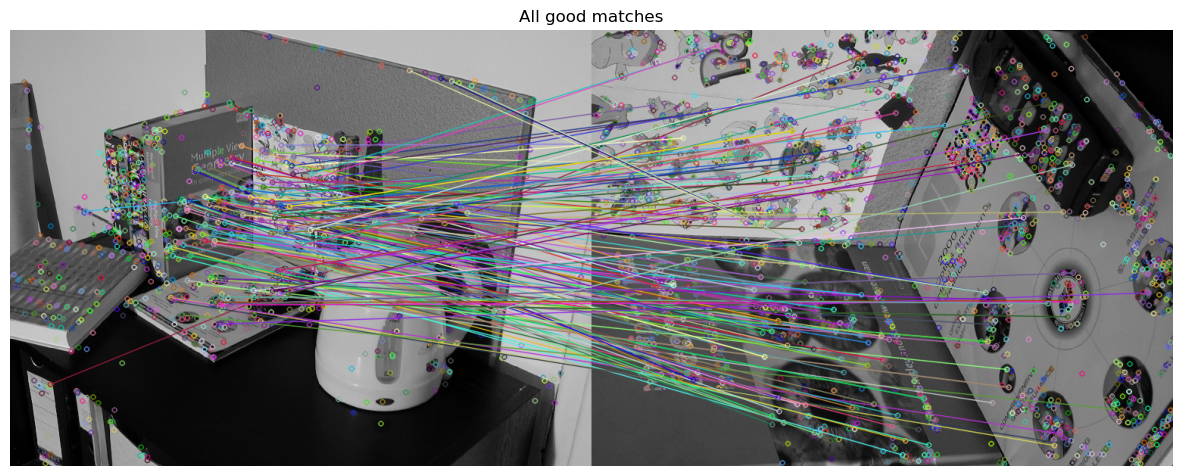


Number of good matches between two images:  157


In [4]:
# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1,des2,k=2)

# Create a mask to draw all good matches
matchesMask = []

# Store all good matches as per Lowe's Ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch
       
        
# Draw all good matches
draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                   #singlePointColor = (255,0,0), #If you want a specific colour
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)

good_matches = cv2.drawMatchesKnn(picA,kp1,picB,kp2,matches,None,**draw_params)


plt.figure(figsize=(15, 15))

plt.imshow(good_matches)
plt.title('All good matches')
plt.axis('off')

plt.show()

# Print total number of good matches between two images
print("\nNumber of good matches between two images: ", len(good))


Number of successful matches between two images:  47


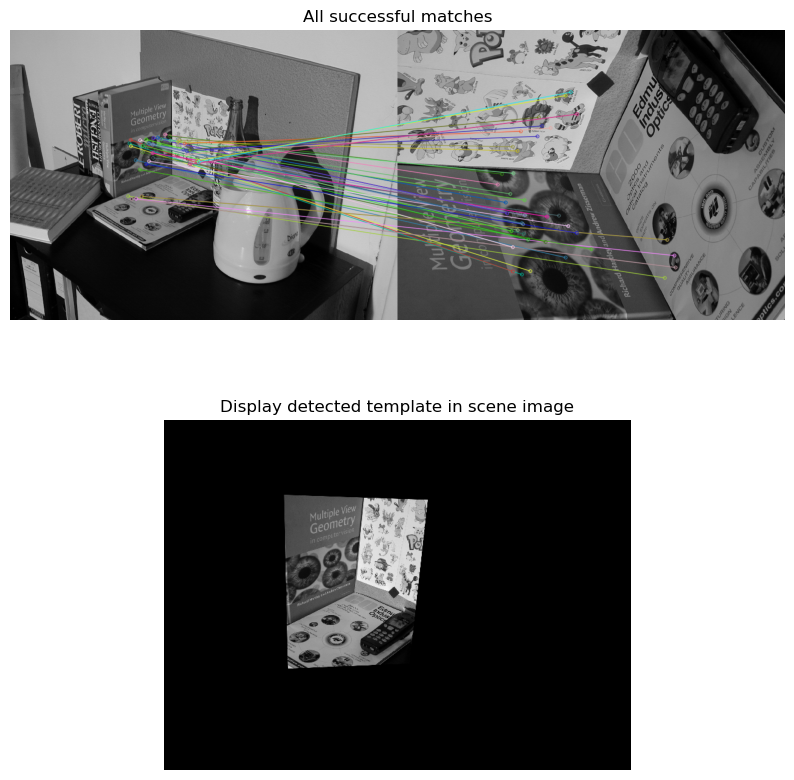

In [5]:
# Now we set a condition that at least N matches (defined by MIN_MATCH_NUM) are required to find the object. 
MIN_MATCH_NUM = 4

if len(good)>= MIN_MATCH_NUM:
    # If enough matches are found, we extract the positions of the matched keypoints in both images. 
    # They are passed to find the perspective transformation. 
    
    # Estimate homography between two images
    ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, status = cv2.findHomography(ptsA, 
                                   ptsB, 
                                   cv2.RANSAC, 
                                   ransacReprojThreshold = 5, 
                                   maxIters = 10) # try to change maxIters and see the effect
    # Where H is the resulting single-strain matrix.
    # status returns a list of feature points that represent successful matches.
    # ptsA, ptsB are keypoints.
    # The three parameters cv2.RANSAC, ransacReprojThreshold, maxIters are related to RANSAC.
    # ransacReprojThreshold: Maximum reprojection error in the RANSAC algorithm to consider a point as an inlier. 
    # maxIters: The maximum number of RANSAC-based robust method iterations.
    
    success = status.ravel().tolist()
    
    # Draw detected template in scene image
    imgOut = cv2.warpPerspective(picB, H, (picA.shape[1],picA.shape[0]),
                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    # Print total number of successful matches between two images
    print("\nNumber of successful matches between two images: ", success.count(1)) # Returns the number of 1 in the success list

else:
    # Otherwise, print that “Not enough matches are found”.
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
    success = None


# Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
draw_params = dict(#matchColor = (0,255,0), # draw in a specific colour
                   #singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = success, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(picA,kp1,picB,kp2,good,None,**draw_params)


# Plotting results
plt.subplots(figsize=(10, 10)) 

if success == None:
    plt.imshow(success_matches)
    plt.title('All matching keypoints')
    plt.axis('off')
    
else:
    plt.subplot(2,1,1)
    plt.imshow(success_matches)
    plt.title('All successful matches')
    plt.axis('off')
    
    plt.subplot(2,1,2)
    plt.imshow(imgOut, 'gray')
    plt.title('Display detected template in scene image')
    plt.axis('off')

plt.show()

### 2. Compute the Fundamental Matrix F using the 8 point algorithm

In [6]:
u = 0
v = 0
up = 0
vp = 0
for i in range(len(ptsA)):
    u += ptsA[i][0][0]
    v += ptsA[i][0][1]
    up += ptsB[i][0][0]
    vp += ptsB[i][0][1]
u /= len(ptsA)
v /= len(ptsA)
up /= len(ptsA)
vp /= len(ptsA)

normalizedA = ptsA.copy()
normalizedB = ptsB.copy()

for i in range(len(normalizedA)):
    normalizedA[i][0][0] -= u
    normalizedA[i][0][1] -= v
    normalizedB[i][0][0] -= up
    normalizedB[i][0][1] -= vp


# calculate scale term
s = 0
sp = 0
for i in range(len(ptsA)):
    s += normalizedA[i][0][0]**2 + normalizedA[i][0][1]**2
    sp += normalizedB[i][0][0]**2 + normalizedB[i][0][1]**2
s = (s / len(ptsA))**0.5
sp = (sp / len(ptsB))**0.5
s = math.sqrt(2)/s
sp = math.sqrt(2)/sp



Ta = np.array([[s,0,0],[0,s,0],[0,0,1]]) @ np.array([[1,0,-u],[0,1,-v],[0,0,1]])
Tb = np.array([[sp,0,0],[0,sp,0],[0,0,1]]) @ np.array([[1,0,-up],[0,1,-vp],[0,0,1]])


nA = []
nB = []
for i in range(len(ptsA)):
    
    nA.append(Ta @ np.append(normalizedA[i][0], 1).reshape(3,1))
    nB.append(Tb @ np.append(normalizedB[i][0], 1).reshape(3,1))

normalizedA = np.array(nA)
normalizedB = np.array(nB)


In [7]:
design_matrix = []
points = []

for _ in range(8):
    index = np.random.randint(normalizedA.shape[0], size=1)[0]
    [[p1],[p2],[_]] = normalizedA[index]
    [[q1],[q2],[_]] = normalizedB[index]

    # Store the 8 points
    points.append([ptsA[index],ptsB[index]])
    # Compute the design matrix from sets of (at least) 8 points
    design_matrix.append([p1*q1,p2*q1,q1,p1*q2,p2*q2,q2,p1,p2,1])

design_matrix = np.array(design_matrix)

# Perform SVD
u, s, vh = np.linalg.svd(design_matrix, full_matrices=False)

# Compose the draft fundamental matrix F
F = vh[-1]
F = F.reshape((3,3))

# Perform an SVD of the draft fundamental matrix
u_F, s_F, vh_F = np.linalg.svd(F, full_matrices=False)

#set the smallest singular value to zero
s_F[-1] = 0

# reassemble F
F = (u_F * s_F) @ vh_F

F_orig = Tb.T @ F @ Ta

for e in points:
    [x,xp] = e
    x = np.append(x,1).reshape(3,1)
    xp = np.append(xp,1).reshape(3,1)
    line = F_orig @ x
    line = line / math.sqrt(line[0]**2 + line[1]**2)
    
    d = abs(xp.T @ line)[0][0]
    print(d)

193.6156199135073
30.713626403826453
167.11665595427837
284.65037977277314
232.3249040694502
54.54424638839913
71.69994924462031
365.8459480734215


In [8]:
# RANSAC
iterations = 2000
values = []
y = []

best_F = []
best_F_orig = []
inliers = []
inliers_norm = []
for _ in range(iterations):
    design_matrix = []
    points = []

    for _ in range(8):
        index = np.random.randint(normalizedA.shape[0], size=1)[0]
        [[p1],[p2],[_]] = normalizedA[index]
        [[q1],[q2],[_]] = normalizedB[index]

        # Store the 8 points
        points.append([ptsA[index],ptsB[index]])
        # Compute the design matrix from sets of (at least) 8 points
        design_matrix.append([p1*q1,p2*q1,q1,p1*q2,p2*q2,q2,p1,p2,1])

    design_matrix = np.array(design_matrix)

    # Perform SVD
    u, s, vh = np.linalg.svd(design_matrix, full_matrices=False)

    # Compose the draft fundamental matrix F
    F = vh[-1]
    F = F.reshape((3,3))

    # Perform an SVD of the draft fundamental matrix
    u_F, s_F, vh_F = np.linalg.svd(F, full_matrices=False)

    #set the smallest singular value to zero
    s_F[-1] = 0

    # reassemble F
    F = (u_F * s_F) @ vh_F

    F_orig = Tb.T @ F @ Ta 

    
    temp1 = []
    temp2 = []
    for i in range(len(ptsA)):
        [p1,p2] = ptsA[i][0]
        [q1,q2] = ptsB[i][0]
        
        x = np.array([[p1],[p2],[1]])
        xp = np.array([[q1],[q2],[1]])

        line = F_orig @ x
        line = line / math.sqrt(line[0]**2 + line[1]**2)
        d = abs(xp.T @ line)
        
        if d < 2:
            temp1.append([ptsA[i][0],ptsB[i][0]])
            temp2.append([normalizedA[i],normalizedB[i]])
            
    if len(temp1) > len(inliers):
        inliers = temp1
        inliers_norm = temp2
        best_F = F
        best_F_orig = F_orig

print(len(inliers))
print(best_F)


47
[[-0.00683641  0.00283636 -0.56625561]
 [-0.00302459  0.00291242 -0.19932377]
 [-0.24536082  0.75725475 -0.07605551]]


In [9]:
# Re-estimate F using all the inliers
design_matrix = []

for e in inliers:
#     [[[p1],[p2],_],[[q1],[q2],_]] = e
    [[p1,p2],[q1,q2]] = e
    # Compute the design matrix from sets of (at least) 8 points
    design_matrix.append([p1*q1,p2*q1,q1,p1*q2,p2*q2,q2,p1,p2,1])

design_matrix = np.array(design_matrix)

# Perform SVD
u, s, vh = np.linalg.svd(design_matrix, full_matrices=False)

# Compose the draft fundamental matrix F
F = vh[-1]
F = F.reshape((3,3))

# Perform an SVD of the draft fundamental matrix
u_F, s_F, vh_F = np.linalg.svd(F, full_matrices=False)

#set the smallest singular value to zero
s_F[-1] = 0

# reassemble F
F = (u_F * s_F) @ vh_F

# F_orig = Tb.T @ F @ Ta 

### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

In [10]:
# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2

def computeCorrespondEpilines(points, F):
    result = []
    for p in points:
        p = np.append(p,1)
        result.append(F @ p)
    return np.array(result)

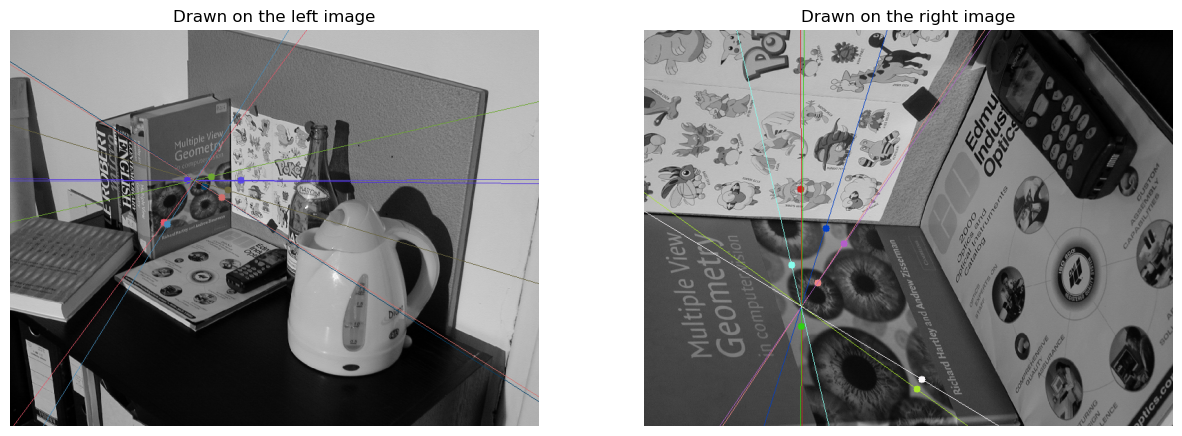

In [11]:
ptsL = []
ptsR = []
for _ in range(10):
    index = np.random.randint(len(inliers), size=1)[0]
    ptsL.append(inliers[index][0])
    ptsR.append(inliers[index][1])
ptsL = np.array(ptsL)
ptsR = np.array(ptsR)

inlierL = np.int32(np.array([pad[:2] for pad in ptsL]))
inlierR = np.int32(np.array([pad[:2] for pad in ptsR]))

# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = computeCorrespondEpilines(ptsR,F.T)
linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(picA, picB, linesL, inlierL, inlierR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = computeCorrespondEpilines(ptsL, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(picB, picA, linesR,inlierR,inlierL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 